In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
from torchvision import models,datasets
from torchvision import transforms
from torch.utils.data import DataLoader
from torchvision.datasets import ImageFolder
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
from efficientnet_pytorch import EfficientNet
import copy
from tqdm import tqdm

if torch.cuda.is_available():
    device = torch.device("cuda")
    print(f"Found GPU at: {torch.cuda.get_device_name(0)}")
else:
    device = torch.device("cpu")
    print("No GPU found, using CPU instead")

Found GPU at: NVIDIA GeForce RTX 4060 Laptop GPU


In [2]:
data_dir = 'Brain Tumor Data Set/Brain Tumor Data Set'
img_size=224

train_transform = transforms.Compose([
    transforms.RandomRotation(40),
    transforms.RandomResizedCrop(img_size),
    transforms.RandomHorizontalFlip(),
    transforms.ToTensor(),
])

val_transform = transforms.Compose([
    transforms.Resize(img_size),
    transforms.CenterCrop(img_size),
    transforms.ToTensor(),
])

train_dataset = datasets.ImageFolder(root=data_dir, transform=train_transform)
val_dataset = datasets.ImageFolder(root=data_dir, transform=val_transform)

In [3]:
train_size = int(0.8 * len(train_dataset))
val_size = len(train_dataset) - train_size
train_dataset, val_dataset = torch.utils.data.random_split(train_dataset, [train_size, val_size])

train_loader = DataLoader(train_dataset, batch_size=128, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=128, shuffle=False)

num_classes = 2
criterion = nn.CrossEntropyLoss()

In [4]:
num_epochs = 50
best_results_efficientnet = {'epoch': 0, 'val_loss': float('inf'), 'accuracy': 0.0, 'precision': 0.0, 'recall': 0.0}

model_efficientnet = EfficientNet.from_pretrained('efficientnet-b0')
in_features = model_efficientnet._fc.in_features
model_efficientnet._fc = nn.Linear(in_features, num_classes)
model_efficientnet = model_efficientnet.to(device)

optimizer_efficientnet = optim.Adam(model_efficientnet.parameters(), lr=0.001)
scheduler_efficientnet = optim.lr_scheduler.StepLR(optimizer_efficientnet, step_size=3, gamma=0.1)

train_losses_efficientnet = []
val_losses_efficientnet = []
val_accuracies_efficientnet = []
precisions_efficientnet = []
recalls_efficientnet = []

for epoch in range(num_epochs):
    torch.cuda.empty_cache()
    model_efficientnet.train()
    running_loss = 0.0
    for inputs, labels in tqdm(train_loader, desc=f"Epoch {epoch+1}/{num_epochs} (EfficientNet)"):
        inputs, labels = inputs.to(device), labels.to(device)
        optimizer_efficientnet.zero_grad()
        outputs = model_efficientnet(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer_efficientnet.step()
        running_loss += loss.item()

    epoch_loss = running_loss / len(train_loader)

    model_efficientnet.eval()
    val_loss = 0.0
    correct = 0
    total = 0
    recall = 0.0
    precision = 0.0
    with torch.no_grad():
        for inputs, labels in val_loader:
            inputs, labels = inputs.to(device), labels.to(device)
            outputs = model_efficientnet(inputs)
            loss = criterion(outputs, labels)
            val_loss += loss.item()
            _, predicted = torch.max(outputs, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()
            recall += recall_score(labels.cpu().numpy(), predicted.cpu().numpy())
            precision += precision_score(labels.cpu().numpy(), predicted.cpu().numpy())

    val_accuracy = correct / total
    val_loss /= len(val_loader)
    recall /= len(val_loader)
    precision /= len(val_loader)

    train_losses_efficientnet.append(epoch_loss)
    val_losses_efficientnet.append(val_loss)
    val_accuracies_efficientnet.append(val_accuracy)
    precisions_efficientnet.append(precision)
    recalls_efficientnet.append(recall)

    print(f"Epoch {epoch+1}/{num_epochs}, Loss: {val_loss}, Accuracy: {val_accuracy}, Precision: {precision}, Recall: {recall}")

    if val_loss < best_results_efficientnet['val_loss']:
        best_results_efficientnet['epoch'] = epoch + 1
        best_results_efficientnet['val_loss'] = val_loss
        best_results_efficientnet['accuracy'] = val_accuracy
        best_results_efficientnet['precision'] = precision
        best_results_efficientnet['recall'] = recall
        best_model_efficientnet = copy.deepcopy(model_efficientnet.state_dict())

    scheduler_efficientnet.step()

torch.save(best_model_efficientnet, 'best_model_efficientnet.pth')

torch.save({
    'train_losses_efficientnet': train_losses_efficientnet,
    'val_losses_efficientnet': val_losses_efficientnet,
    'val_accuracies_efficientnet': val_accuracies_efficientnet,
    'precisions_efficientnet': precisions_efficientnet,
    'recalls_efficientnet': recalls_efficientnet
}, 'metrics_efficientnet.pth')

Loaded pretrained weights for efficientnet-b0


Epoch 1/50 (EfficientNet): 100%|██████████| 29/29 [06:27<00:00, 13.35s/it]


Epoch 1/50, Loss: 0.9869755804538727, Accuracy: 0.8206521739130435, Precision: 0.8729587024321237, Recall: 0.6968925550146328


Epoch 2/50 (EfficientNet): 100%|██████████| 29/29 [05:54<00:00, 12.22s/it]


Epoch 2/50, Loss: 0.9450005292892456, Accuracy: 0.8315217391304348, Precision: 0.8196488788565448, Recall: 0.787611665985972


Epoch 3/50 (EfficientNet): 100%|██████████| 29/29 [05:45<00:00, 11.93s/it]


Epoch 3/50, Loss: 0.3482014648616314, Accuracy: 0.8869565217391304, Precision: 0.8770296450974523, Recall: 0.8659063886872916


Epoch 4/50 (EfficientNet): 100%|██████████| 29/29 [05:40<00:00, 11.73s/it]


Epoch 4/50, Loss: 0.22681312076747417, Accuracy: 0.908695652173913, Precision: 0.9186286903221054, Recall: 0.8802082689404157


Epoch 5/50 (EfficientNet): 100%|██████████| 29/29 [05:34<00:00, 11.54s/it]


Epoch 5/50, Loss: 0.22953198663890362, Accuracy: 0.9173913043478261, Precision: 0.9106417470659275, Recall: 0.9030073000099209


Epoch 6/50 (EfficientNet): 100%|██████████| 29/29 [05:20<00:00, 11.05s/it]


Epoch 6/50, Loss: 0.18218974955379963, Accuracy: 0.9315217391304348, Precision: 0.9184970516975275, Recall: 0.9339416127049456


Epoch 7/50 (EfficientNet): 100%|██████████| 29/29 [05:42<00:00, 11.81s/it]


Epoch 7/50, Loss: 0.1990502756088972, Accuracy: 0.9304347826086956, Precision: 0.8913693438817029, Recall: 0.9431333087998598


Epoch 8/50 (EfficientNet): 100%|██████████| 29/29 [05:17<00:00, 10.94s/it]


Epoch 8/50, Loss: 0.1272548483684659, Accuracy: 0.9478260869565217, Precision: 0.9229977107174806, Recall: 0.9663095533527208


Epoch 9/50 (EfficientNet): 100%|██████████| 29/29 [05:29<00:00, 11.37s/it]


Epoch 9/50, Loss: 0.11741121858358383, Accuracy: 0.9478260869565217, Precision: 0.9194923692680423, Recall: 0.9685729149910823


Epoch 10/50 (EfficientNet): 100%|██████████| 29/29 [05:06<00:00, 10.57s/it]


Epoch 10/50, Loss: 0.12202564440667629, Accuracy: 0.9543478260869566, Precision: 0.9195575064770112, Recall: 0.9639637693880004


Epoch 11/50 (EfficientNet): 100%|██████████| 29/29 [04:52<00:00, 10.08s/it]


Epoch 11/50, Loss: 0.15371505450457335, Accuracy: 0.95, Precision: 0.9184216233192646, Recall: 0.9548052901553686


Epoch 12/50 (EfficientNet): 100%|██████████| 29/29 [04:52<00:00, 10.07s/it]


Epoch 12/50, Loss: 0.13597643934190273, Accuracy: 0.9489130434782609, Precision: 0.9300310492515129, Recall: 0.9595642279774823


Epoch 13/50 (EfficientNet): 100%|██████████| 29/29 [04:47<00:00,  9.92s/it]


Epoch 13/50, Loss: 0.12214650865644217, Accuracy: 0.9532608695652174, Precision: 0.9427419561133551, Recall: 0.9434548969136746


Epoch 14/50 (EfficientNet): 100%|██████████| 29/29 [04:49<00:00,  9.98s/it]


Epoch 14/50, Loss: 0.11825008504092693, Accuracy: 0.9510869565217391, Precision: 0.9503436158105161, Recall: 0.9425493862964185


Epoch 15/50 (EfficientNet): 100%|██████████| 29/29 [04:33<00:00,  9.45s/it]


Epoch 15/50, Loss: 0.13094549905508757, Accuracy: 0.9489130434782609, Precision: 0.9273393648957075, Recall: 0.9499997137670191


Epoch 16/50 (EfficientNet): 100%|██████████| 29/29 [04:37<00:00,  9.58s/it]


Epoch 16/50, Loss: 0.14013532176613808, Accuracy: 0.9521739130434783, Precision: 0.9566945399189218, Recall: 0.9257481367593784


Epoch 17/50 (EfficientNet): 100%|██████████| 29/29 [04:33<00:00,  9.44s/it]


Epoch 17/50, Loss: 0.11544524971395731, Accuracy: 0.9576086956521739, Precision: 0.9482161865960756, Recall: 0.9459679977782056


Epoch 18/50 (EfficientNet): 100%|██████████| 29/29 [04:35<00:00,  9.50s/it]


Epoch 18/50, Loss: 0.12611235119402409, Accuracy: 0.9489130434782609, Precision: 0.9454642445493414, Recall: 0.9305094616809256


Epoch 19/50 (EfficientNet): 100%|██████████| 29/29 [04:30<00:00,  9.32s/it]


Epoch 19/50, Loss: 0.12777610775083303, Accuracy: 0.9586956521739131, Precision: 0.956286083179009, Recall: 0.9390131865048307


Epoch 20/50 (EfficientNet): 100%|██████████| 29/29 [04:41<00:00,  9.70s/it]


Epoch 20/50, Loss: 0.11748063564300537, Accuracy: 0.9630434782608696, Precision: 0.9609740501930935, Recall: 0.945912761427035


Epoch 21/50 (EfficientNet): 100%|██████████| 29/29 [04:45<00:00,  9.85s/it]


Epoch 21/50, Loss: 0.09407456358894706, Accuracy: 0.9608695652173913, Precision: 0.9664485218153084, Recall: 0.9542809903999906


Epoch 22/50 (EfficientNet): 100%|██████████| 29/29 [04:23<00:00,  9.10s/it]


Epoch 22/50, Loss: 0.10353915533050895, Accuracy: 0.9608695652173913, Precision: 0.958882422950788, Recall: 0.9531311830125115


Epoch 23/50 (EfficientNet): 100%|██████████| 29/29 [04:25<00:00,  9.15s/it]


Epoch 23/50, Loss: 0.09498375561088324, Accuracy: 0.9586956521739131, Precision: 0.9609506374775563, Recall: 0.942512611250283


Epoch 24/50 (EfficientNet): 100%|██████████| 29/29 [04:28<00:00,  9.27s/it]


Epoch 24/50, Loss: 0.10764899663627148, Accuracy: 0.9576086956521739, Precision: 0.9631765891767398, Recall: 0.9392920620437424


Epoch 25/50 (EfficientNet): 100%|██████████| 29/29 [04:31<00:00,  9.35s/it]


Epoch 25/50, Loss: 0.11588504537940025, Accuracy: 0.9565217391304348, Precision: 0.965448133844188, Recall: 0.936125803593202


Epoch 26/50 (EfficientNet): 100%|██████████| 29/29 [04:30<00:00,  9.32s/it]


Epoch 26/50, Loss: 0.10232011927291751, Accuracy: 0.9565217391304348, Precision: 0.9547278902834213, Recall: 0.9553982573929334


Epoch 27/50 (EfficientNet): 100%|██████████| 29/29 [04:25<00:00,  9.15s/it]


Epoch 27/50, Loss: 0.10102626215666533, Accuracy: 0.9608695652173913, Precision: 0.9479302236591328, Recall: 0.9452248023960016


Epoch 28/50 (EfficientNet): 100%|██████████| 29/29 [04:28<00:00,  9.27s/it]


Epoch 28/50, Loss: 0.0994717781431973, Accuracy: 0.9619565217391305, Precision: 0.9502954883670477, Recall: 0.952740393266995


Epoch 29/50 (EfficientNet): 100%|██████████| 29/29 [04:24<00:00,  9.13s/it]


Epoch 29/50, Loss: 0.12287353724241257, Accuracy: 0.9586956521739131, Precision: 0.9494438958076583, Recall: 0.9364153704091058


Epoch 30/50 (EfficientNet): 100%|██████████| 29/29 [04:27<00:00,  9.22s/it]


Epoch 30/50, Loss: 0.111252058763057, Accuracy: 0.966304347826087, Precision: 0.9682248906430749, Recall: 0.945793078408782


Epoch 31/50 (EfficientNet): 100%|██████████| 29/29 [04:29<00:00,  9.29s/it]


Epoch 31/50, Loss: 0.08497468056157231, Accuracy: 0.9652173913043478, Precision: 0.9669329069955993, Recall: 0.9545279991991984


Epoch 32/50 (EfficientNet): 100%|██████████| 29/29 [04:24<00:00,  9.13s/it]


Epoch 32/50, Loss: 0.10760465124621987, Accuracy: 0.9521739130434783, Precision: 0.9543093845623326, Recall: 0.9270119301784812


Epoch 33/50 (EfficientNet): 100%|██████████| 29/29 [04:28<00:00,  9.25s/it]


Epoch 33/50, Loss: 0.08603273681364954, Accuracy: 0.967391304347826, Precision: 0.9594436417278979, Recall: 0.9572091363092148


Epoch 34/50 (EfficientNet): 100%|██████████| 29/29 [04:29<00:00,  9.29s/it]


Epoch 34/50, Loss: 0.10046979924663901, Accuracy: 0.9608695652173913, Precision: 0.9561752089055388, Recall: 0.9579212552284313


Epoch 35/50 (EfficientNet): 100%|██████████| 29/29 [04:25<00:00,  9.17s/it]


Epoch 35/50, Loss: 0.09177580894902349, Accuracy: 0.967391304347826, Precision: 0.963882338355331, Recall: 0.960355044241021


Epoch 36/50 (EfficientNet): 100%|██████████| 29/29 [04:22<00:00,  9.07s/it]


Epoch 36/50, Loss: 0.08619757974520326, Accuracy: 0.9554347826086956, Precision: 0.9564564069207346, Recall: 0.9434355996410807


Epoch 37/50 (EfficientNet): 100%|██████████| 29/29 [04:23<00:00,  9.09s/it]


Epoch 37/50, Loss: 0.10163202229887247, Accuracy: 0.9510869565217391, Precision: 0.9396856362968427, Recall: 0.9526112602269637


Epoch 38/50 (EfficientNet): 100%|██████████| 29/29 [04:27<00:00,  9.23s/it]


Epoch 38/50, Loss: 0.08754301397129893, Accuracy: 0.9630434782608696, Precision: 0.949037746389677, Recall: 0.9599034361830697


Epoch 39/50 (EfficientNet): 100%|██████████| 29/29 [04:27<00:00,  9.21s/it]


Epoch 39/50, Loss: 0.0956995072774589, Accuracy: 0.9597826086956521, Precision: 0.9620609621012115, Recall: 0.9476745649574954


Epoch 40/50 (EfficientNet): 100%|██████████| 29/29 [04:29<00:00,  9.28s/it]


Epoch 40/50, Loss: 0.10520512238144875, Accuracy: 0.9597826086956521, Precision: 0.9482375328680656, Recall: 0.940379967234694


Epoch 41/50 (EfficientNet): 100%|██████████| 29/29 [04:27<00:00,  9.22s/it]


Epoch 41/50, Loss: 0.1255718469619751, Accuracy: 0.9641304347826087, Precision: 0.9547320078806771, Recall: 0.9643313358695902


Epoch 42/50 (EfficientNet): 100%|██████████| 29/29 [04:24<00:00,  9.12s/it]


Epoch 42/50, Loss: 0.11742771277204156, Accuracy: 0.9576086956521739, Precision: 0.9362372113232812, Recall: 0.9595622878272371


Epoch 43/50 (EfficientNet): 100%|██████████| 29/29 [04:27<00:00,  9.22s/it]


Epoch 43/50, Loss: 0.11550516355782747, Accuracy: 0.9619565217391305, Precision: 0.9442849140598996, Recall: 0.9589882288438963


Epoch 44/50 (EfficientNet): 100%|██████████| 29/29 [04:30<00:00,  9.33s/it]


Epoch 44/50, Loss: 0.10398544510826468, Accuracy: 0.9543478260869566, Precision: 0.9421941640185837, Recall: 0.958265063080184


Epoch 45/50 (EfficientNet): 100%|██████████| 29/29 [04:26<00:00,  9.20s/it]


Epoch 45/50, Loss: 0.12299779709428549, Accuracy: 0.9597826086956521, Precision: 0.9459415261619649, Recall: 0.9526597557724275


Epoch 46/50 (EfficientNet): 100%|██████████| 29/29 [04:27<00:00,  9.24s/it]


Epoch 46/50, Loss: 0.09200782887637615, Accuracy: 0.9608695652173913, Precision: 0.9457331309021884, Recall: 0.956673320332867


Epoch 47/50 (EfficientNet): 100%|██████████| 29/29 [04:27<00:00,  9.21s/it]


Epoch 47/50, Loss: 0.08888336271047592, Accuracy: 0.9608695652173913, Precision: 0.9602992383300674, Recall: 0.9594392810852941


Epoch 48/50 (EfficientNet): 100%|██████████| 29/29 [04:25<00:00,  9.15s/it]


Epoch 48/50, Loss: 0.12901940289884806, Accuracy: 0.9532608695652174, Precision: 0.9455240570549384, Recall: 0.9522639276422243


Epoch 49/50 (EfficientNet): 100%|██████████| 29/29 [04:27<00:00,  9.21s/it]


Epoch 49/50, Loss: 0.11564743937924504, Accuracy: 0.9608695652173913, Precision: 0.9450127250043879, Recall: 0.9572050802396269


Epoch 50/50 (EfficientNet): 100%|██████████| 29/29 [04:29<00:00,  9.30s/it]


Epoch 50/50, Loss: 0.11316380370408297, Accuracy: 0.9543478260869566, Precision: 0.934471816796709, Recall: 0.9552863554263046


In [5]:
model_mobilenet = models.mobilenet_v2(pretrained=True)
num_ftrs = model_mobilenet.classifier[1].in_features
model_mobilenet.classifier[1] = nn.Linear(num_ftrs, 2)
model_mobilenet = model_mobilenet.to(device)

optimizer_mobilenet = optim.Adam(model_mobilenet.parameters(), lr=0.001)
scheduler_mobilenet = optim.lr_scheduler.StepLR(optimizer_mobilenet, step_size=3, gamma=0.1)

best_results_mobilenet = {'epoch': 0, 'val_loss': float('inf'), 'accuracy': 0.0, 'precision': 0.0, 'recall': 0.0}

train_losses_mobilenet = []
val_losses_mobilenet = []
val_accuracies_mobilenet = []
precisions_mobilenet = []
recalls_mobilenet = []

for epoch in range(num_epochs):
    model_mobilenet.train()
    running_loss = 0.0
    for inputs, labels in tqdm(train_loader, desc=f"Epoch {epoch+1}/{num_epochs} (MobileNet)"):
        inputs, labels = inputs.to(device), labels.to(device)
        optimizer_mobilenet.zero_grad()
        outputs = model_mobilenet(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer_mobilenet.step()
        running_loss += loss.item()

    epoch_loss = running_loss / len(train_loader)

    model_mobilenet.eval()
    val_loss = 0.0
    correct = 0
    total = 0
    recall = 0.0
    precision = 0.0
    with torch.no_grad():
        for inputs, labels in val_loader:
            inputs, labels = inputs.to(device), labels.to(device)
            outputs = model_mobilenet(inputs)
            loss = criterion(outputs, labels)
            val_loss += loss.item()
            _, predicted = torch.max(outputs, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()
            recall += recall_score(labels.cpu().numpy(), predicted.cpu().numpy())
            precision += precision_score(labels.cpu().numpy(), predicted.cpu().numpy())

    val_accuracy = correct / total
    val_loss /= len(val_loader)
    recall /= len(val_loader)
    precision /= len(val_loader)

    train_losses_mobilenet.append(epoch_loss)
    val_losses_mobilenet.append(val_loss)
    val_accuracies_mobilenet.append(val_accuracy)
    precisions_mobilenet.append(precision)
    recalls_mobilenet.append(recall)

    print(f"Epoch {epoch+1}/{num_epochs}, Loss: {val_loss}, Accuracy: {val_accuracy}, Precision: {precision}, Recall: {recall}")

    if val_loss < best_results_mobilenet['val_loss']:
        best_results_mobilenet['epoch'] = epoch + 1
        best_results_mobilenet['val_loss'] = val_loss
        best_results_mobilenet['accuracy'] = val_accuracy
        best_results_mobilenet['precision'] = precision
        best_results_mobilenet['recall'] = recall
        best_model_mobilenet = copy.deepcopy(model_mobilenet.state_dict())

    scheduler_mobilenet.step()

torch.save(best_model_mobilenet, 'best_model_mobilenet.pth')

torch.save({
    'train_losses_mobilenet': train_losses_mobilenet,
    'val_losses_mobilenet': val_losses_mobilenet,
    'val_accuracies_mobilenet': val_accuracies_mobilenet,
    'precisions_mobilenet': precisions_mobilenet,
    'recalls_mobilenet': recalls_mobilenet
}, 'metrics_mobilenet.pth')

C:\Users\Timur\anaconda3\envs\Timur\lib\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
C:\Users\Timur\anaconda3\envs\Timur\lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=MobileNet_V2_Weights.IMAGENET1K_V1`. You can also use `weights=MobileNet_V2_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Epoch 1/50 (MobileNet): 100%|██████████| 29/29 [02:35<00:00,  5.38s/it]


Epoch 1/50, Loss: 0.40887918323278427, Accuracy: 0.8532608695652174, Precision: 0.7984309004122251, Recall: 0.897049948790981


Epoch 2/50 (MobileNet): 100%|██████████| 29/29 [02:36<00:00,  5.40s/it]


Epoch 2/50, Loss: 0.2311815842986107, Accuracy: 0.9054347826086957, Precision: 0.8508455734262752, Recall: 0.9557607732498604


Epoch 3/50 (MobileNet): 100%|██████████| 29/29 [02:36<00:00,  5.40s/it]


Epoch 3/50, Loss: 0.27712322771549225, Accuracy: 0.8706521739130435, Precision: 0.9335731526035904, Recall: 0.7462925724461833


Epoch 4/50 (MobileNet): 100%|██████████| 29/29 [02:36<00:00,  5.39s/it]


Epoch 4/50, Loss: 0.19744069874286652, Accuracy: 0.9163043478260869, Precision: 0.8586649894495455, Recall: 0.937183635847155


Epoch 5/50 (MobileNet): 100%|██████████| 29/29 [02:36<00:00,  5.41s/it]


Epoch 5/50, Loss: 0.16703742370009422, Accuracy: 0.9293478260869565, Precision: 0.9267408263409908, Recall: 0.8996151898249083


Epoch 6/50 (MobileNet): 100%|██████████| 29/29 [02:36<00:00,  5.39s/it]


Epoch 6/50, Loss: 0.16737472265958786, Accuracy: 0.9260869565217391, Precision: 0.9021075244632265, Recall: 0.9210031062869772


Epoch 7/50 (MobileNet): 100%|██████████| 29/29 [02:35<00:00,  5.37s/it]


Epoch 7/50, Loss: 0.16146807745099068, Accuracy: 0.9380434782608695, Precision: 0.9119492229303062, Recall: 0.9367099727967824


Epoch 8/50 (MobileNet): 100%|██████████| 29/29 [02:36<00:00,  5.40s/it]


Epoch 8/50, Loss: 0.18872370943427086, Accuracy: 0.9315217391304348, Precision: 0.8992027352657174, Recall: 0.9368153015161345


Epoch 9/50 (MobileNet): 100%|██████████| 29/29 [02:36<00:00,  5.41s/it]


Epoch 9/50, Loss: 0.14890018664300442, Accuracy: 0.9391304347826087, Precision: 0.9144602839769184, Recall: 0.9352522216757769


Epoch 10/50 (MobileNet): 100%|██████████| 29/29 [02:36<00:00,  5.41s/it]


Epoch 10/50, Loss: 0.13621818833053112, Accuracy: 0.9521739130434783, Precision: 0.9275111578812574, Recall: 0.9462490981038248


Epoch 11/50 (MobileNet): 100%|██████████| 29/29 [02:36<00:00,  5.40s/it]


Epoch 11/50, Loss: 0.15743189956992865, Accuracy: 0.9456521739130435, Precision: 0.909969271065805, Recall: 0.9571203287446529


Epoch 12/50 (MobileNet): 100%|██████████| 29/29 [02:36<00:00,  5.40s/it]


Epoch 12/50, Loss: 0.14764783158898354, Accuracy: 0.941304347826087, Precision: 0.9116534277177348, Recall: 0.9514508916407477


Epoch 13/50 (MobileNet): 100%|██████████| 29/29 [02:36<00:00,  5.40s/it]


Epoch 13/50, Loss: 0.15635478124022484, Accuracy: 0.9380434782608695, Precision: 0.9159451850459178, Recall: 0.9408428191171287


Epoch 14/50 (MobileNet): 100%|██████████| 29/29 [02:36<00:00,  5.39s/it]


Epoch 14/50, Loss: 0.13190644048154354, Accuracy: 0.9391304347826087, Precision: 0.9234245666330795, Recall: 0.9309559265161345


Epoch 15/50 (MobileNet): 100%|██████████| 29/29 [02:36<00:00,  5.39s/it]


Epoch 15/50, Loss: 0.16097591258585453, Accuracy: 0.9369565217391305, Precision: 0.9059701927903626, Recall: 0.9411206911300515


Epoch 16/50 (MobileNet): 100%|██████████| 29/29 [02:36<00:00,  5.39s/it]


Epoch 16/50, Loss: 0.1631815955042839, Accuracy: 0.941304347826087, Precision: 0.9155561517683527, Recall: 0.9403938371042312


Epoch 17/50 (MobileNet): 100%|██████████| 29/29 [02:36<00:00,  5.39s/it]


Epoch 17/50, Loss: 0.13257579877972603, Accuracy: 0.9489130434782609, Precision: 0.9236953146967503, Recall: 0.9557239138163123


Epoch 18/50 (MobileNet): 100%|██████████| 29/29 [02:36<00:00,  5.39s/it]


Epoch 18/50, Loss: 0.16697296407073736, Accuracy: 0.9358695652173913, Precision: 0.9205314600891842, Recall: 0.9312202924376909


Epoch 19/50 (MobileNet): 100%|██████████| 29/29 [02:37<00:00,  5.44s/it]


Epoch 19/50, Loss: 0.14432890433818102, Accuracy: 0.9434782608695652, Precision: 0.9204476494194282, Recall: 0.9508393811435252


Epoch 20/50 (MobileNet): 100%|██████████| 29/29 [02:37<00:00,  5.43s/it]


Epoch 20/50, Loss: 0.15868602693080902, Accuracy: 0.9380434782608695, Precision: 0.9102040984679707, Recall: 0.9491307314957592


Epoch 21/50 (MobileNet): 100%|██████████| 29/29 [02:37<00:00,  5.43s/it]


Epoch 21/50, Loss: 0.15390356443822384, Accuracy: 0.9423913043478261, Precision: 0.9184725532198516, Recall: 0.9476192829154823


Epoch 22/50 (MobileNet): 100%|██████████| 29/29 [02:37<00:00,  5.44s/it]


Epoch 22/50, Loss: 0.14689529314637184, Accuracy: 0.9489130434782609, Precision: 0.9261899597190442, Recall: 0.9431458905069459


Epoch 23/50 (MobileNet): 100%|██████████| 29/29 [02:37<00:00,  5.44s/it]


Epoch 23/50, Loss: 0.12117235641926527, Accuracy: 0.9532608695652174, Precision: 0.925132136523518, Recall: 0.9554100945141455


Epoch 24/50 (MobileNet): 100%|██████████| 29/29 [02:37<00:00,  5.44s/it]


Epoch 24/50, Loss: 0.15164720732718706, Accuracy: 0.9478260869565217, Precision: 0.92271825495722, Recall: 0.9533372864958926


Epoch 25/50 (MobileNet): 100%|██████████| 29/29 [02:38<00:00,  5.45s/it]


Epoch 25/50, Loss: 0.16657439898699522, Accuracy: 0.9315217391304348, Precision: 0.9116438049780051, Recall: 0.9309408358420267


Epoch 26/50 (MobileNet): 100%|██████████| 29/29 [02:37<00:00,  5.44s/it]


Epoch 26/50, Loss: 0.11648460105061531, Accuracy: 0.9510869565217391, Precision: 0.9341692136800447, Recall: 0.9473328852650613


Epoch 27/50 (MobileNet): 100%|██████████| 29/29 [02:37<00:00,  5.43s/it]


Epoch 27/50, Loss: 0.15272617107257247, Accuracy: 0.9402173913043478, Precision: 0.9075829577550982, Recall: 0.945774003812523


Epoch 28/50 (MobileNet): 100%|██████████| 29/29 [02:37<00:00,  5.44s/it]


Epoch 28/50, Loss: 0.16087597701698542, Accuracy: 0.9369565217391305, Precision: 0.9084106175846289, Recall: 0.9474514224390941


Epoch 29/50 (MobileNet): 100%|██████████| 29/29 [02:37<00:00,  5.42s/it]


Epoch 29/50, Loss: 0.15242152102291584, Accuracy: 0.941304347826087, Precision: 0.9228804502529065, Recall: 0.9404061933220685


Epoch 30/50 (MobileNet): 100%|██████████| 29/29 [02:37<00:00,  5.43s/it]


Epoch 30/50, Loss: 0.14843915309756994, Accuracy: 0.9456521739130435, Precision: 0.9209332653284746, Recall: 0.9545525481057517


Epoch 31/50 (MobileNet): 100%|██████████| 29/29 [02:37<00:00,  5.43s/it]


Epoch 31/50, Loss: 0.13257028814405203, Accuracy: 0.9521739130434783, Precision: 0.9355432438886827, Recall: 0.947781134932061


Epoch 32/50 (MobileNet): 100%|██████████| 29/29 [02:37<00:00,  5.43s/it]


Epoch 32/50, Loss: 0.1787061868235469, Accuracy: 0.941304347826087, Precision: 0.9086621751618617, Recall: 0.9581176497499189


Epoch 33/50 (MobileNet): 100%|██████████| 29/29 [02:37<00:00,  5.44s/it]


Epoch 33/50, Loss: 0.1349952295422554, Accuracy: 0.9532608695652174, Precision: 0.9318015691090206, Recall: 0.956387408328205


Epoch 34/50 (MobileNet): 100%|██████████| 29/29 [02:38<00:00,  5.46s/it]


Epoch 34/50, Loss: 0.1227022921666503, Accuracy: 0.9489130434782609, Precision: 0.9205945299600756, Recall: 0.970999583150509


Epoch 35/50 (MobileNet): 100%|██████████| 29/29 [02:37<00:00,  5.45s/it]


Epoch 35/50, Loss: 0.14305756893008947, Accuracy: 0.9532608695652174, Precision: 0.9300759641201166, Recall: 0.957175623026642


Epoch 36/50 (MobileNet): 100%|██████████| 29/29 [02:38<00:00,  5.45s/it]


Epoch 36/50, Loss: 0.11259672464802861, Accuracy: 0.9489130434782609, Precision: 0.9348262139995814, Recall: 0.9609914686393627


Epoch 37/50 (MobileNet): 100%|██████████| 29/29 [02:38<00:00,  5.45s/it]


Epoch 37/50, Loss: 0.15498657152056694, Accuracy: 0.9554347826086956, Precision: 0.9315624374519207, Recall: 0.9590734537446529


Epoch 38/50 (MobileNet): 100%|██████████| 29/29 [02:38<00:00,  5.47s/it]


Epoch 38/50, Loss: 0.1688352506607771, Accuracy: 0.9402173913043478, Precision: 0.9269258583909493, Recall: 0.9311759952800464


Epoch 39/50 (MobileNet): 100%|██████████| 29/29 [02:54<00:00,  6.00s/it]


Epoch 39/50, Loss: 0.1323243323713541, Accuracy: 0.9456521739130435, Precision: 0.9226280155421942, Recall: 0.9508541284901052


Epoch 40/50 (MobileNet): 100%|██████████| 29/29 [02:47<00:00,  5.79s/it]


Epoch 40/50, Loss: 0.15747839584946632, Accuracy: 0.9402173913043478, Precision: 0.91136064286358, Recall: 0.9418148009391252


Epoch 41/50 (MobileNet): 100%|██████████| 29/29 [02:37<00:00,  5.44s/it]


Epoch 41/50, Loss: 0.1519734556786716, Accuracy: 0.9391304347826087, Precision: 0.9136783885872691, Recall: 0.9491995318691147


Epoch 42/50 (MobileNet): 100%|██████████| 29/29 [02:37<00:00,  5.44s/it]


Epoch 42/50, Loss: 0.14773468859493732, Accuracy: 0.9489130434782609, Precision: 0.9324053985816315, Recall: 0.9458865700069218


Epoch 43/50 (MobileNet): 100%|██████████| 29/29 [02:38<00:00,  5.46s/it]


Epoch 43/50, Loss: 0.12311712466180325, Accuracy: 0.9521739130434783, Precision: 0.9252438601703308, Recall: 0.9538174151425723


Epoch 44/50 (MobileNet): 100%|██████████| 29/29 [02:38<00:00,  5.45s/it]


Epoch 44/50, Loss: 0.15357998572289944, Accuracy: 0.941304347826087, Precision: 0.9110849333786444, Recall: 0.9440096211442464


Epoch 45/50 (MobileNet): 100%|██████████| 29/29 [02:38<00:00,  5.45s/it]


Epoch 45/50, Loss: 0.13500194437801838, Accuracy: 0.9489130434782609, Precision: 0.9314690565027307, Recall: 0.9570199429989941


Epoch 46/50 (MobileNet): 100%|██████████| 29/29 [02:38<00:00,  5.45s/it]


Epoch 46/50, Loss: 0.15414837934076786, Accuracy: 0.9434782608695652, Precision: 0.9177069400614287, Recall: 0.9494331646552113


Epoch 47/50 (MobileNet): 100%|██████████| 29/29 [02:38<00:00,  5.45s/it]


Epoch 47/50, Loss: 0.1724264593794942, Accuracy: 0.9304347826086956, Precision: 0.8928941468846558, Recall: 0.9410220445253411


Epoch 48/50 (MobileNet): 100%|██████████| 29/29 [02:37<00:00,  5.44s/it]


Epoch 48/50, Loss: 0.16403881274163723, Accuracy: 0.9402173913043478, Precision: 0.9259166385609657, Recall: 0.9343615510031805


Epoch 49/50 (MobileNet): 100%|██████████| 29/29 [02:38<00:00,  5.45s/it]


Epoch 49/50, Loss: 0.16085371747612953, Accuracy: 0.933695652173913, Precision: 0.9156042779212187, Recall: 0.9419771386014628


Epoch 50/50 (MobileNet): 100%|██████████| 29/29 [02:37<00:00,  5.44s/it]


Epoch 50/50, Loss: 0.12727472931146622, Accuracy: 0.9456521739130435, Precision: 0.9145060701097478, Recall: 0.9600342464039224


In [8]:
model_resnet = models.resnet50(pretrained=True)
num_ftrs = model_resnet.fc.in_features
model_resnet.fc = nn.Linear(num_ftrs, 2)
model_resnet = model_resnet.to(device)

optimizer_resnet = optim.Adam(model_resnet.parameters(), lr=0.001)
scheduler_resnet = optim.lr_scheduler.StepLR(optimizer_resnet, step_size=3, gamma=0.1)

best_results_resnet = {'epoch': 0, 'val_loss': float('inf'), 'accuracy': 0.0, 'precision': 0.0, 'recall': 0.0}

train_losses_resnet = []
val_losses_resnet = []
val_accuracies_resnet = []
precisions_resnet = []
recalls_resnet = []

for epoch in range(num_epochs):
    model_resnet.train()
    running_loss = 0.0
    for inputs, labels in tqdm(train_loader, desc=f"Epoch {epoch+1}/{num_epochs} (ResNet-50)"):
        inputs, labels = inputs.to(device), labels.to(device)
        optimizer_resnet.zero_grad()
        outputs = model_resnet(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer_resnet.step()
        running_loss += loss.item()

    epoch_loss = running_loss / len(train_loader)

    model_resnet.eval()
    val_loss = 0.0
    correct = 0
    total = 0
    recall = 0.0
    precision = 0.0
    with torch.no_grad():
        for inputs, labels in val_loader:
            inputs, labels = inputs.to(device), labels.to(device)
            outputs = model_resnet(inputs)
            loss = criterion(outputs, labels)
            val_loss += loss.item()
            _, predicted = torch.max(outputs, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()
            recall += recall_score(labels.cpu().numpy(), predicted.cpu().numpy())
            precision += precision_score(labels.cpu().numpy(), predicted.cpu().numpy())


    val_accuracy = correct / total
    val_loss /= len(val_loader)
    recall /= len(val_loader)
    precision /= len(val_loader)

    train_losses_resnet.append(epoch_loss)
    val_losses_resnet.append(val_loss)
    val_accuracies_resnet.append(val_accuracy)
    precisions_resnet.append(precision)
    recalls_resnet.append(recall)

    print(f"Epoch {epoch+1}/{num_epochs}, Loss: {val_loss}, Accuracy: {val_accuracy}, Precision: {precision}, Recall: {recall}")

    if val_loss < best_results_resnet['val_loss']:
        best_results_resnet['epoch'] = epoch + 1
        best_results_resnet['val_loss'] = val_loss
        best_results_resnet['accuracy'] = val_accuracy
        best_results_resnet['precision'] = precision
        best_results_resnet['recall'] = recall
        best_model_resnet = copy.deepcopy(model_resnet.state_dict())

    scheduler_resnet.step()

torch.save(best_model_resnet, 'best_model_resnet.pth')

torch.save({
    'train_losses_resnet': train_losses_resnet,
    'val_losses_resnet': val_losses_resnet,
    'val_accuracies_resnet': val_accuracies_resnet,
    'precisions_resnet': precisions_resnet,
    'recalls_resnet': recalls_resnet
}, 'metrics_resnet.pth')

C:\Users\Timur\anaconda3\envs\Timur\lib\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
C:\Users\Timur\anaconda3\envs\Timur\lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet50_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet50_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/resnet50-0676ba61.pth" to C:\Users\Timur/.cache\torch\hub\checkpoints\resnet50-0676ba61.pth
100%|██████████| 97.8M/97.8M [00:15<00:00, 6.54MB/s]
Epoch 1/50 (ResNet-50): 100%|██████████| 29/29 [09:04<00:00, 18.78s/it]


Epoch 1/50, Loss: 2.736578479409218, Accuracy: 0.6108695652173913, Precision: 0.8320707070707072, Recall: 0.15655531358313904


Epoch 2/50 (ResNet-50): 100%|██████████| 29/29 [07:36<00:00, 15.76s/it]


Epoch 2/50, Loss: 1.0263717994093895, Accuracy: 0.7293478260869565, Precision: 0.905725090127264, Recall: 0.4486811947306541


Epoch 3/50 (ResNet-50): 100%|██████████| 29/29 [08:33<00:00, 17.71s/it]


Epoch 3/50, Loss: 0.3609137497842312, Accuracy: 0.8565217391304348, Precision: 0.7955469060185016, Recall: 0.8979776110280475


Epoch 4/50 (ResNet-50): 100%|██████████| 29/29 [07:49<00:00, 16.18s/it]


Epoch 4/50, Loss: 0.2783131990581751, Accuracy: 0.8923913043478261, Precision: 0.8030020796272053, Recall: 0.971011019013375


Epoch 5/50 (ResNet-50): 100%|██████████| 29/29 [08:52<00:00, 18.35s/it]


Epoch 5/50, Loss: 0.23607910424470901, Accuracy: 0.9152173913043479, Precision: 0.8646149069483042, Recall: 0.936449569586487


Epoch 6/50 (ResNet-50): 100%|██████████| 29/29 [08:42<00:00, 18.03s/it]


Epoch 6/50, Loss: 0.23800302110612392, Accuracy: 0.9119565217391304, Precision: 0.8530713770162209, Recall: 0.944710353920748


Epoch 7/50 (ResNet-50): 100%|██████████| 29/29 [08:42<00:00, 18.03s/it]


Epoch 7/50, Loss: 0.20661795884370804, Accuracy: 0.9173913043478261, Precision: 0.8837626669919622, Recall: 0.922909959311826


Epoch 8/50 (ResNet-50): 100%|██████████| 29/29 [08:38<00:00, 17.88s/it]


Epoch 8/50, Loss: 0.18900538608431816, Accuracy: 0.9239130434782609, Precision: 0.8902238463632579, Recall: 0.9324572424488866


Epoch 9/50 (ResNet-50): 100%|██████████| 29/29 [08:19<00:00, 17.22s/it]


Epoch 9/50, Loss: 0.17703319527208805, Accuracy: 0.9380434782608695, Precision: 0.9003295824623173, Recall: 0.9503694084079275


Epoch 10/50 (ResNet-50): 100%|██████████| 29/29 [09:32<00:00, 19.76s/it]


Epoch 10/50, Loss: 0.1897754780948162, Accuracy: 0.9315217391304348, Precision: 0.8891856933389192, Recall: 0.9562633136728604


Epoch 11/50 (ResNet-50): 100%|██████████| 29/29 [10:02<00:00, 20.78s/it]


Epoch 11/50, Loss: 0.19240761175751686, Accuracy: 0.9108695652173913, Precision: 0.8788832001180946, Recall: 0.9396106110703295


Epoch 12/50 (ResNet-50): 100%|██████████| 29/29 [10:19<00:00, 21.35s/it]


Epoch 12/50, Loss: 0.1962580904364586, Accuracy: 0.925, Precision: 0.8804831946874047, Recall: 0.9490994670236982


Epoch 13/50 (ResNet-50): 100%|██████████| 29/29 [10:11<00:00, 21.10s/it]


Epoch 13/50, Loss: 0.18198448978364468, Accuracy: 0.9228260869565217, Precision: 0.8918505896999717, Recall: 0.9368350497672259


Epoch 14/50 (ResNet-50): 100%|██████████| 29/29 [09:12<00:00, 19.04s/it]


Epoch 14/50, Loss: 0.1999368667602539, Accuracy: 0.9228260869565217, Precision: 0.8892832656570253, Recall: 0.9199369726683798


Epoch 15/50 (ResNet-50): 100%|██████████| 29/29 [09:11<00:00, 19.00s/it]


Epoch 15/50, Loss: 0.20966141857206821, Accuracy: 0.9206521739130434, Precision: 0.874225172075704, Recall: 0.9365944534990871


Epoch 16/50 (ResNet-50): 100%|██████████| 29/29 [09:28<00:00, 19.61s/it]


Epoch 16/50, Loss: 0.19561711326241493, Accuracy: 0.9326086956521739, Precision: 0.9029428419453995, Recall: 0.929524107875127


Epoch 17/50 (ResNet-50): 100%|██████████| 29/29 [09:17<00:00, 19.22s/it]


Epoch 17/50, Loss: 0.19965162221342325, Accuracy: 0.925, Precision: 0.8910729963652306, Recall: 0.92207311898967


Epoch 18/50 (ResNet-50): 100%|██████████| 29/29 [09:08<00:00, 18.92s/it]


Epoch 18/50, Loss: 0.1944800578057766, Accuracy: 0.9206521739130434, Precision: 0.8753871961468401, Recall: 0.9453726528682693


Epoch 19/50 (ResNet-50): 100%|██████████| 29/29 [09:04<00:00, 18.79s/it]


Epoch 19/50, Loss: 0.2082351502031088, Accuracy: 0.9163043478260869, Precision: 0.8710586611048451, Recall: 0.9378146580826392


Epoch 20/50 (ResNet-50): 100%|██████████| 29/29 [09:03<00:00, 18.74s/it]


Epoch 20/50, Loss: 0.16217103321105242, Accuracy: 0.933695652173913, Precision: 0.8977602567193749, Recall: 0.956790473933455


Epoch 21/50 (ResNet-50): 100%|██████████| 29/29 [08:21<00:00, 17.30s/it]


Epoch 21/50, Loss: 0.17825772799551487, Accuracy: 0.9282608695652174, Precision: 0.8996902061920836, Recall: 0.9287578405181415


Epoch 22/50 (ResNet-50): 100%|██████████| 29/29 [08:19<00:00, 17.24s/it]


Epoch 22/50, Loss: 0.19186330400407314, Accuracy: 0.9130434782608695, Precision: 0.8618231458474342, Recall: 0.9452728469629679


Epoch 23/50 (ResNet-50): 100%|██████████| 29/29 [08:19<00:00, 17.22s/it]


Epoch 23/50, Loss: 0.18403325602412224, Accuracy: 0.9152173913043479, Precision: 0.8754541611845111, Recall: 0.9291531373117434


Epoch 24/50 (ResNet-50): 100%|██████████| 29/29 [08:19<00:00, 17.21s/it]


Epoch 24/50, Loss: 0.2057914398610592, Accuracy: 0.9271739130434783, Precision: 0.8834120977468903, Recall: 0.9385005937924096


Epoch 25/50 (ResNet-50): 100%|██████████| 29/29 [08:21<00:00, 17.29s/it]


Epoch 25/50, Loss: 0.17119693011045456, Accuracy: 0.9423913043478261, Precision: 0.910683875323251, Recall: 0.9562705511479073


Epoch 26/50 (ResNet-50): 100%|██████████| 29/29 [08:19<00:00, 17.23s/it]


Epoch 26/50, Loss: 0.19428560882806778, Accuracy: 0.9206521739130434, Precision: 0.8772971561482787, Recall: 0.9411682166003926


Epoch 27/50 (ResNet-50): 100%|██████████| 29/29 [08:19<00:00, 17.22s/it]


Epoch 27/50, Loss: 0.16792929358780384, Accuracy: 0.9315217391304348, Precision: 0.8941863285003909, Recall: 0.9316521175772893


Epoch 28/50 (ResNet-50): 100%|██████████| 29/29 [08:19<00:00, 17.22s/it]


Epoch 28/50, Loss: 0.18908872082829475, Accuracy: 0.9228260869565217, Precision: 0.8899226488854574, Recall: 0.9384808952614695


Epoch 29/50 (ResNet-50): 100%|██████████| 29/29 [08:21<00:00, 17.30s/it]


Epoch 29/50, Loss: 0.18753699027001858, Accuracy: 0.9282608695652174, Precision: 0.8863003014104086, Recall: 0.9480945529758815


Epoch 30/50 (ResNet-50): 100%|██████████| 29/29 [08:19<00:00, 17.23s/it]


Epoch 30/50, Loss: 0.20025295950472355, Accuracy: 0.925, Precision: 0.8918085374335691, Recall: 0.9301189186355482


Epoch 31/50 (ResNet-50): 100%|██████████| 29/29 [08:19<00:00, 17.22s/it]


Epoch 31/50, Loss: 0.18872182816267014, Accuracy: 0.9293478260869565, Precision: 0.8896399655349424, Recall: 0.9585938067144232


Epoch 32/50 (ResNet-50): 100%|██████████| 29/29 [08:23<00:00, 17.35s/it]


Epoch 32/50, Loss: 0.17152113746851683, Accuracy: 0.9271739130434783, Precision: 0.8912305146187495, Recall: 0.9297121056209765


Epoch 33/50 (ResNet-50): 100%|██████████| 29/29 [08:33<00:00, 17.71s/it]


Epoch 33/50, Loss: 0.19926298595964909, Accuracy: 0.9206521739130434, Precision: 0.8859745515499171, Recall: 0.9309929861987322


Epoch 34/50 (ResNet-50): 100%|██████████| 29/29 [08:23<00:00, 17.38s/it]


Epoch 34/50, Loss: 0.23227517679333687, Accuracy: 0.9097826086956522, Precision: 0.8526909197843564, Recall: 0.9294969451634961


Epoch 35/50 (ResNet-50): 100%|██████████| 29/29 [08:22<00:00, 17.31s/it]


Epoch 35/50, Loss: 0.19190534949302673, Accuracy: 0.925, Precision: 0.891483766348705, Recall: 0.9338441119444554


Epoch 36/50 (ResNet-50): 100%|██████████| 29/29 [08:21<00:00, 17.28s/it]


Epoch 36/50, Loss: 0.1931852400302887, Accuracy: 0.9282608695652174, Precision: 0.9034120083306539, Recall: 0.9342620174943651


Epoch 37/50 (ResNet-50): 100%|██████████| 29/29 [08:21<00:00, 17.30s/it]


Epoch 37/50, Loss: 0.20374445617198944, Accuracy: 0.9271739130434783, Precision: 0.8906107977452318, Recall: 0.9285024969034229


Epoch 38/50 (ResNet-50): 100%|██████████| 29/29 [08:21<00:00, 17.29s/it]


Epoch 38/50, Loss: 0.17464420199394226, Accuracy: 0.9304347826086956, Precision: 0.8990110595420138, Recall: 0.9343078535439088


Epoch 39/50 (ResNet-50): 100%|██████████| 29/29 [08:21<00:00, 17.31s/it]


Epoch 39/50, Loss: 0.217458201572299, Accuracy: 0.9260869565217391, Precision: 0.8752263467401629, Recall: 0.9431922701330668


Epoch 40/50 (ResNet-50): 100%|██████████| 29/29 [08:20<00:00, 17.25s/it]


Epoch 40/50, Loss: 0.20172618702054024, Accuracy: 0.9195652173913044, Precision: 0.8789030342622812, Recall: 0.9265993219533729


Epoch 41/50 (ResNet-50): 100%|██████████| 29/29 [08:23<00:00, 17.35s/it]


Epoch 41/50, Loss: 0.20325930789113045, Accuracy: 0.9195652173913044, Precision: 0.8711804306493466, Recall: 0.9323141563683005


Epoch 42/50 (ResNet-50): 100%|██████████| 29/29 [08:22<00:00, 17.32s/it]


Epoch 42/50, Loss: 0.2010971587151289, Accuracy: 0.9304347826086956, Precision: 0.8981570119107227, Recall: 0.9495580993074236


Epoch 43/50 (ResNet-50): 100%|██████████| 29/29 [08:21<00:00, 17.31s/it]


Epoch 43/50, Loss: 0.19256222993135452, Accuracy: 0.9173913043478261, Precision: 0.8986457178212505, Recall: 0.9262987000823061


Epoch 44/50 (ResNet-50): 100%|██████████| 29/29 [08:22<00:00, 17.33s/it]


Epoch 44/50, Loss: 0.17512775026261806, Accuracy: 0.9184782608695652, Precision: 0.8775929705168779, Recall: 0.93314316994799


Epoch 45/50 (ResNet-50): 100%|██████████| 29/29 [08:23<00:00, 17.38s/it]


Epoch 45/50, Loss: 0.18243965227156878, Accuracy: 0.9304347826086956, Precision: 0.8877946540422038, Recall: 0.9369599346992867


Epoch 46/50 (ResNet-50): 100%|██████████| 29/29 [08:19<00:00, 17.23s/it]


Epoch 46/50, Loss: 0.19120530039072037, Accuracy: 0.9173913043478261, Precision: 0.8826472360686567, Recall: 0.9249342595446391


Epoch 47/50 (ResNet-50): 100%|██████████| 29/29 [08:19<00:00, 17.22s/it]


Epoch 47/50, Loss: 0.19353367947041988, Accuracy: 0.9206521739130434, Precision: 0.8757422490773582, Recall: 0.9368873289857912


Epoch 48/50 (ResNet-50): 100%|██████████| 29/29 [08:20<00:00, 17.27s/it]


Epoch 48/50, Loss: 0.1857252661138773, Accuracy: 0.9195652173913044, Precision: 0.8787988146667183, Recall: 0.9356422211445773


Epoch 49/50 (ResNet-50): 100%|██████████| 29/29 [08:28<00:00, 17.54s/it]


Epoch 49/50, Loss: 0.19119339250028133, Accuracy: 0.925, Precision: 0.8886749182705534, Recall: 0.9304324789976


Epoch 50/50 (ResNet-50): 100%|██████████| 29/29 [08:38<00:00, 17.87s/it]


Epoch 50/50, Loss: 0.22673790901899338, Accuracy: 0.908695652173913, Precision: 0.8501049018115646, Recall: 0.9433877777504495


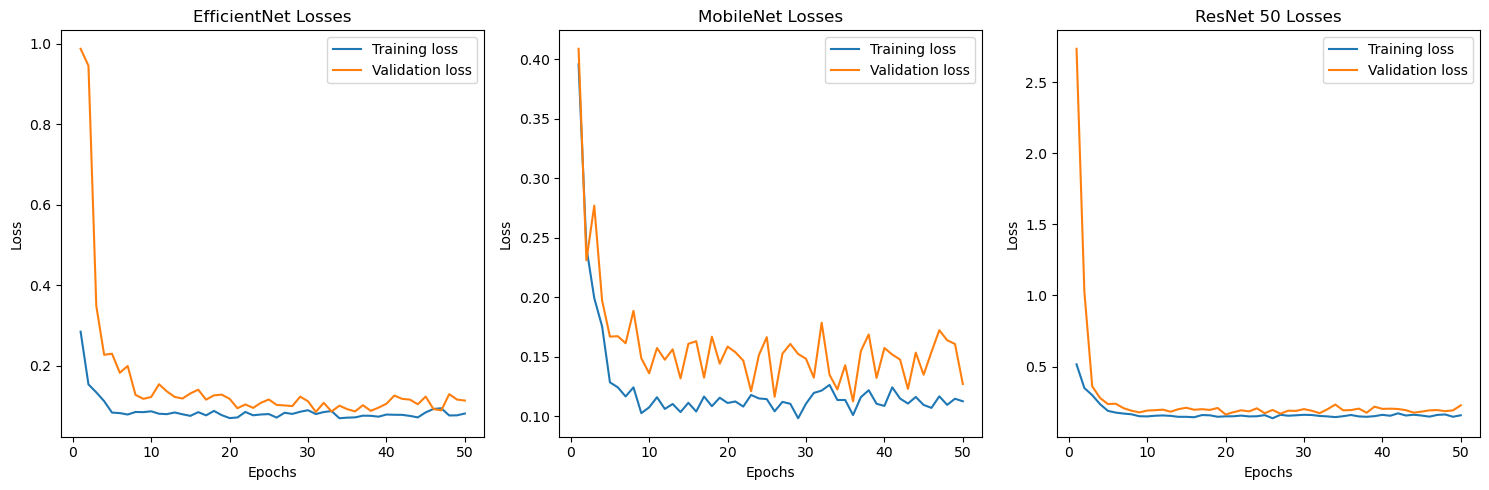

In [16]:
import matplotlib.pyplot as plt


plt.figure(figsize=(15, 5))
epochs=range(1, 51)
plt.subplot(1, 3, 1)
plt.plot(epochs, train_losses_efficientnet, label='Training loss')
plt.plot(epochs, val_losses_efficientnet, label='Validation loss')
plt.title('EfficientNet Losses')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.subplot(1, 3, 3)
plt.plot(epochs, train_losses_resnet, label='Training loss')
plt.plot(epochs, val_losses_resnet, label='Validation loss')
plt.title('ResNet 50 Losses')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.subplot(1, 3, 2)
plt.plot(epochs, train_losses_mobilenet, label='Training loss')
plt.plot(epochs, val_losses_mobilenet, label='Validation loss')
plt.title('MobileNet Losses')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.tight_layout()
plt.show()

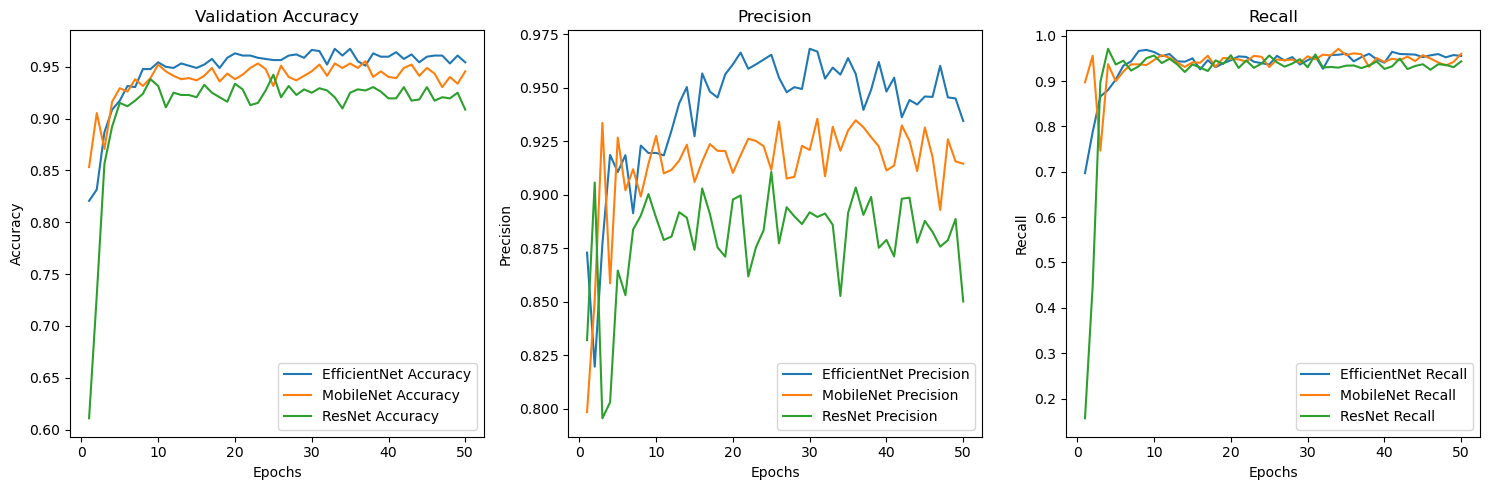

In [17]:
plt.figure(figsize=(15, 5))

# Accuracy
plt.subplot(1, 3, 1)
plt.plot(epochs, val_accuracies_efficientnet, label='EfficientNet Accuracy')
plt.plot(epochs, val_accuracies_mobilenet, label='MobileNet Accuracy')
plt.plot(epochs, val_accuracies_resnet, label='ResNet Accuracy')
plt.title('Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

# Precision
plt.subplot(1, 3, 2)
plt.plot(epochs, precisions_efficientnet, label='EfficientNet Precision')
plt.plot(epochs, precisions_mobilenet, label='MobileNet Precision')
plt.plot(epochs, precisions_resnet, label='ResNet Precision')
plt.title('Precision')
plt.xlabel('Epochs')
plt.ylabel('Precision')
plt.legend()

# Recall
plt.subplot(1, 3, 3)
plt.plot(epochs, recalls_efficientnet, label='EfficientNet Recall')
plt.plot(epochs, recalls_mobilenet, label='MobileNet Recall')
plt.plot(epochs, recalls_resnet, label='ResNet Recall')
plt.title('Recall')
plt.xlabel('Epochs')
plt.ylabel('Recall')
plt.legend()

plt.tight_layout()
plt.show()

C:\Users\Timur\anaconda3\envs\Timur\lib\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
C:\Users\Timur\anaconda3\envs\Timur\lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=None`.
  warnings.warn(msg)


EfficientNet-b0 Metrics:
F1 Score: 0.9824
Accuracy: 0.9815
Precision: 0.9916
Recall: 0.9734
Specificity: 0.9907

MobileNet_v2 Metrics:
F1 Score: 0.9622
Accuracy: 0.9598
Precision: 0.9593
Recall: 0.9652
Specificity: 0.9537

Resnet50 Metrics:
F1 Score: 0.9391
Accuracy: 0.9370
Precision: 0.9634
Recall: 0.9160
Specificity: 0.9606



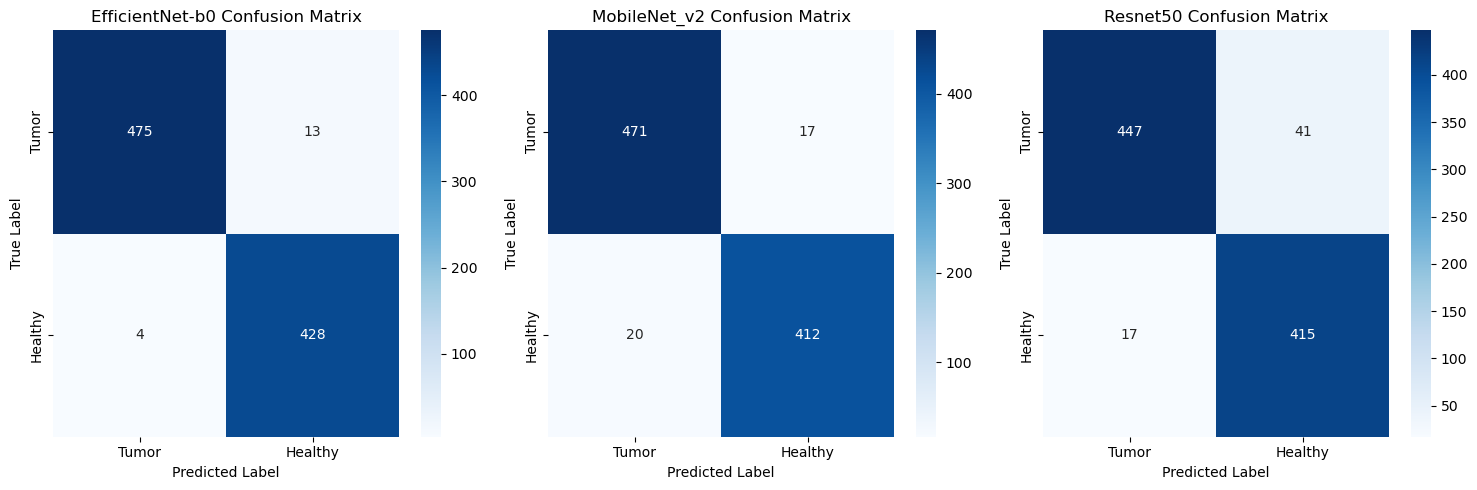

In [6]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torchvision.models import mobilenet_v2, resnet50
from efficientnet_pytorch import EfficientNet
from sklearn.metrics import confusion_matrix
import seaborn as sns
import numpy as np
import matplotlib.pyplot as plt
import time
import random




model_dict = {
    'EfficientNet-b0': EfficientNet.from_name('efficientnet-b0').to(device),
    'MobileNet_v2': mobilenet_v2(pretrained=False).to(device),
    'Resnet50': resnet50(pretrained=False).to(device)
}

num_ftrs = model_dict['EfficientNet-b0']._fc.in_features
model_dict['EfficientNet-b0']._fc = nn.Linear(num_ftrs, 2).to(device)

num_ftrs = model_dict['MobileNet_v2'].classifier[1].in_features
model_dict['MobileNet_v2'].classifier[1] = nn.Linear(num_ftrs, 2).to(device)

num_ftrs = model_dict['Resnet50'].fc.in_features
model_dict['Resnet50'].fc = nn.Linear(num_ftrs, 2).to(device)

best_model_efficientnet = torch.load('best_model_efficientnet.pth')
model_dict['EfficientNet-b0'].load_state_dict(best_model_efficientnet)

best_model_mobilenet = torch.load('best_model_mobilenet.pth')
model_dict['MobileNet_v2'].load_state_dict(best_model_mobilenet)

best_model_resnet = torch.load('best_model_resnet.pth')
model_dict['Resnet50'].load_state_dict(best_model_resnet)


for model in model_dict.values():
    model.eval()


def predict_labels(model, dataloader):
    model.eval()
    all_predictions = []
    all_labels = []
    with torch.no_grad():
        for inputs, labels in dataloader:
            inputs, labels = inputs.to(device), labels.to(device)
            outputs = model(inputs)
            predictions = F.softmax(outputs, dim=1)
            all_predictions.extend(predictions.cpu().numpy())
            all_labels.extend(labels.cpu().numpy())
    return all_predictions, all_labels

batch_inputs, batch_labels = next(iter(val_loader))
batch_inputs, batch_labels = batch_inputs[:100].to(device), batch_labels[:100].to(device)

predictions = {}
for model_name, model in model_dict.items():
    pred_probabilities, ground_truth_labels = predict_labels(model, val_loader)
    predictions[model_name] = pred_probabilities


metrics = {}
for model_name, pred_probabilities in predictions.items():
    pred_labels = np.argmax(pred_probabilities, axis=1)
    confusion_mat = confusion_matrix(ground_truth_labels, pred_labels)
    accuracy = (confusion_mat[0, 0]+confusion_mat[1, 1]) / (confusion_mat[0, 0] + confusion_mat[0, 1] + confusion_mat[1, 0] + confusion_mat[1, 1])
    precision = confusion_mat[0, 0] / (confusion_mat[0, 0] + confusion_mat[1, 0])
    recall = confusion_mat[0, 0] / (confusion_mat[0, 0] + confusion_mat[0, 1])
    f1 = (2*precision*recall)/(precision+recall)
    specificity = confusion_mat[1, 1] / (confusion_mat[1, 1] + confusion_mat[1, 0])
    metrics[model_name] = {'F1 Score': f1, 'Accuracy': accuracy, 
                           'Precision': precision, 'Recall': recall, 
                            'Specificity': specificity}


for model_name, metric_values in metrics.items():
    print(f'{model_name} Metrics:')
    for metric_name, value in metric_values.items():
        print(f'{metric_name}: {value:.4f}')
    print()


confusion_matrices = {}
for model_name, pred_probabilities in predictions.items():
    pred_labels = np.argmax(pred_probabilities, axis=1)
    cm = confusion_matrix(ground_truth_labels, pred_labels)
    confusion_matrices[model_name] = cm


plt.figure(figsize=(15, 5))
for i, (model_name, cm) in enumerate(confusion_matrices.items()):
    plt.subplot(1, len(confusion_matrices), i + 1)
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
    plt.title(f'{model_name} Confusion Matrix')
    plt.xlabel('Predicted Label')
    plt.ylabel('True Label')
    plt.gca().set_ylim(len(cm), 0)
    plt.xticks(ticks=[0.5, 1.5], labels=['Tumor', 'Healthy'])
    plt.yticks(ticks=[0.5, 1.5], labels=['Tumor', 'Healthy'])
plt.tight_layout()
plt.show()

In [21]:
import os

def plot_predictions(model, inputs, labels, class_names, model_name):
    model.eval()
    with torch.no_grad():
        outputs = model(inputs)
        predictions = F.softmax(outputs, dim=1)
        pred_labels = torch.argmax(predictions, dim=1)
        incorrect_indices = (pred_labels != labels).nonzero().cpu().numpy().flatten()

        batch_size = 9
        num_batches = 1
        for i in range(num_batches):
            fig, axes = plt.subplots(3, 3, figsize=(20, 20))
            for j, ax in enumerate(axes.flatten()):
                idx = i * batch_size + j
                if idx >= len(inputs):
                    break
                ax.imshow(inputs[idx].cpu().permute(1, 2, 0))
                ax.axis('off')
                if idx in incorrect_indices:
                    ax.set_title(f'Incorrect\nPredicted: {class_names[pred_labels[idx].item()]}\nActual: {class_names[labels[idx].item()]}', color='red', fontsize=20)
                else:
                    ax.set_title(f'Predicted: {class_names[pred_labels[idx].item()]}\nActual: {class_names[labels[idx].item()]}', fontsize=20)
            plt.tight_layout()
            plt.savefig(f"{model_name}_batch_{i}.jpg")
            plt.close()

class_names = ['Tumor', 'Healthy']
for model_name, model in model_dict.items():
    plot_predictions(model, batch_inputs, batch_labels, class_names, model_name)



In [10]:
import torch

file_paths = {
    'metrics_EfficientNet-b0': 'metrics_efficientnet.pth',
    'metrics_MobileNet_v2': 'metrics_mobilenet.pth',
    'metrics_Resnet50': 'metrics_resnet.pth'
}

metrics_dict = {}

for model_name, file_path in file_paths.items():
    metrics_dict[model_name] = torch.load(file_path)

print("Metrics downloaded successfully.")

Metrics downloaded successfully.


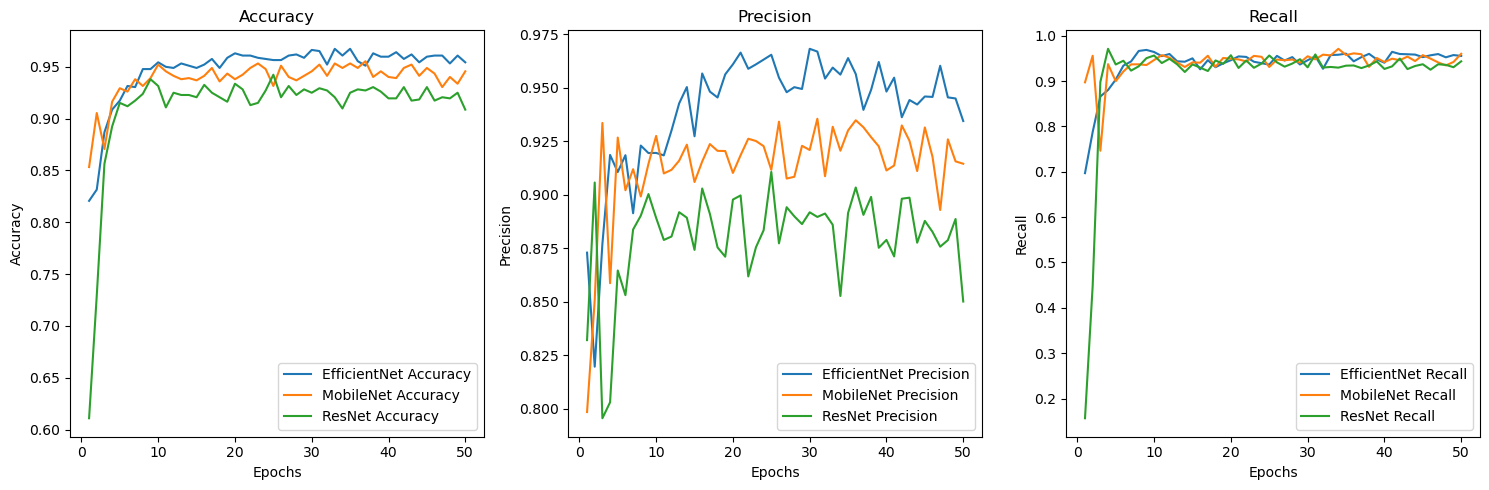

In [17]:
import matplotlib.pyplot as plt


val_accuracies_efficientnet = metrics_dict['metrics_EfficientNet-b0']['val_accuracies_efficientnet']
precisions_efficientnet =  metrics_dict['metrics_EfficientNet-b0']['precisions_efficientnet']
recalls_efficientnet =  metrics_dict['metrics_EfficientNet-b0']['recalls_efficientnet']

val_accuracies_mobilenet = metrics_dict['metrics_MobileNet_v2']['val_accuracies_mobilenet']
precisions_mobilenet = metrics_dict['metrics_MobileNet_v2']['precisions_mobilenet']
recalls_mobilenet = metrics_dict['metrics_MobileNet_v2']['recalls_mobilenet']

val_accuracies_resnet = metrics_dict['metrics_Resnet50']['val_accuracies_resnet']
precisions_resnet = metrics_dict['metrics_Resnet50']['precisions_resnet']
recalls_resnet = metrics_dict['metrics_Resnet50']['recalls_resnet']
epochs = range(1, len(train_losses_efficientnet) + 1)

plt.figure(figsize=(15, 5))

plt.subplot(1, 3, 1)
plt.plot(epochs, val_accuracies_efficientnet, label='EfficientNet Accuracy')
plt.plot(epochs, val_accuracies_mobilenet, label='MobileNet Accuracy')
plt.plot(epochs, val_accuracies_resnet, label='ResNet Accuracy')
plt.title('Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

plt.subplot(1, 3, 2)
plt.plot(epochs, precisions_efficientnet, label='EfficientNet Precision')
plt.plot(epochs, precisions_mobilenet, label='MobileNet Precision')
plt.plot(epochs, precisions_resnet, label='ResNet Precision')
plt.title('Precision')
plt.xlabel('Epochs')
plt.ylabel('Precision')
plt.legend()

plt.subplot(1, 3, 3)
plt.plot(epochs, recalls_efficientnet, label='EfficientNet Recall')
plt.plot(epochs, recalls_mobilenet, label='MobileNet Recall')
plt.plot(epochs, recalls_resnet, label='ResNet Recall')
plt.title('Recall')
plt.xlabel('Epochs')
plt.ylabel('Recall')
plt.legend()

plt.tight_layout()
plt.show()
